# Introduction
Research suggests that speech production can be modeled as a nonlinear dynamical system, wherein small perturbations in the interaction of its parts give rise to chaotic yet deterministic behavior. Parkinson's-related impairments (e.g. tremors, etc.) to the vocal organs, muscles and nerves can affect dynamics of the entire system, suggesting that nonlinear measures  may benefit the prediction of disease stage from voice recordings. 

## Features
### Traditional measures:
  * **age**
  * **sex**
  * **shimmer** - extent of variation in amplitude from vocal cycle to vocal cycle
  * **noise-to-harmonics ratio (NHR)** -  amplitude of noise relative to tonal components of speech signal
  * **jitter** - measures pitch variation, such as vibrato and microtremor; calculated as differences in absolute frequencies of each cycle, averaged over a number of cycles
      - *Note*: Natural pitch variation exists in healthy individuals, but may be perturbed in those with vocal impairments secondary to Parkinson's. 
  
### Complex dynamical systems-based measures:

  * **correlation dimension** - used to recreate all possible states (phase space) of the system that generates speech  
  * **recurrence period density entropy (RPDE)** - this entropy measures the periodicity of the system
      - When the signal deviates from its trajectory of recurring to the same point in the phase space, this may indicate a voice disorder. Many voice disorders impair the patient's ability to sustain vocal fold vibration, which can be measured as in terms of aperiodicity.  
    
  * **detrended fluctuation analysis (DFA)** - extent of stochastic self-similarity of noise in the speech signal
      - Air blowing over vocal folds is a major cause of noise in speech, the pattern of which may be disrupted in some voice disorders. This noise can be characterized by a scaling exponent, which is higher in those with vocal disorders.  
      
  * **pitch period entropy (PPE)** - this entropy provides another measure of pitch variation (compare to **jitter**)
      - Because pitch is produced and perceived on a logarithmic scale, PPE is calculated first by converting a pitch sequence to the logarithmic semitone scale. A filter then removes natural pitch variations (such as those due to gender and individual differences), and a probability distribution of voice variations is constructed. Finally, entropy is calculated, characterizing the extent of variation beyond natural fluctuations in pitch. Increased PPE may suggest speech variations beyond those seen in healthy speech production.
      
### Target feature:

We will predict total scores on the [Unified Parkinson's disease rating scale (UPDRS)](https://neurosurgery.mgh.harvard.edu/functional/pdstages.htm), the scale most commonly used to study the long-term course of the disease. 

# Setting Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings 

warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set()
pd.options.display.max_columns=None

In [2]:
data_path = '../Data/'
df = pd.read_csv(data_path+"data.csv")

# Exploratory Data Analysis

## Descriptive statistics and data cleaning

In [3]:
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
subject#         5875 non-null int64
age              5875 non-null int64
sex              5875 non-null int64
test_time        5875 non-null float64
motor_UPDRS      5875 non-null float64
total_UPDRS      5875 non-null float64
Jitter(%)        5875 non-null float64
Jitter(Abs)      5875 non-null float64
Jitter:RAP       5875 non-null float64
Jitter:PPQ5      5875 non-null float64
Jitter:DDP       5875 non-null float64
Shimmer          5875 non-null float64
Shimmer(dB)      5875 non-null float64
Shimmer:APQ3     5875 non-null float64
Shimmer:APQ5     5875 non-null float64
Shimmer:APQ11    5875 non-null float64
Shimmer:DDA      5875 non-null float64
NHR              5875 non-null float64
HNR              5875 non-null float64
RPDE             5875 non-null float64
DFA              5875 non-null float64
PPE              5875 non-null float64
dtypes: float64(19), int64(3)
memory usag

In [5]:
df.describe()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,0.008962,0.034035,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,0.009371,0.025835,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,0.004730,0.019120,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,0.006750,0.027510,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,0.009870,0.039750,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


In [6]:
def gender(val):
    if val == 1:
        return "F"
    return "M"
df.sex = df.sex.apply(gender)
df.age = df.age.astype("int")
df

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,M,5.64310,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.160060
1,1,72,M,12.66600,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.108100
2,1,72,M,19.68100,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.210140
3,1,72,M,25.64700,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.332770
4,1,72,M,33.64200,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.193610
5,1,72,M,40.65200,29.435,36.870,0.00353,0.000023,0.00119,0.00159,0.00357,0.02227,0.214,0.01006,0.01337,0.02263,0.03019,0.009438,22.946,0.53949,0.57243,0.195000
6,1,72,M,47.64900,29.682,37.363,0.00422,0.000024,0.00212,0.00221,0.00637,0.04352,0.445,0.02376,0.02621,0.03488,0.07128,0.013260,22.506,0.49250,0.54779,0.175630
7,1,72,M,54.64000,29.928,37.857,0.00476,0.000025,0.00226,0.00259,0.00678,0.02191,0.212,0.00979,0.01462,0.01911,0.02937,0.027969,22.929,0.47712,0.54234,0.238440
8,1,72,M,61.66900,30.177,38.353,0.00432,0.000029,0.00156,0.00207,0.00468,0.04296,0.371,0.01774,0.02134,0.03451,0.05323,0.013381,22.078,0.51563,0.61864,0.200370
9,1,72,M,68.68800,30.424,38.849,0.00496,0.000027,0.00258,0.00253,0.00773,0.03610,0.310,0.02030,0.01970,0.02569,0.06089,0.018021,22.606,0.50032,0.58673,0.201170


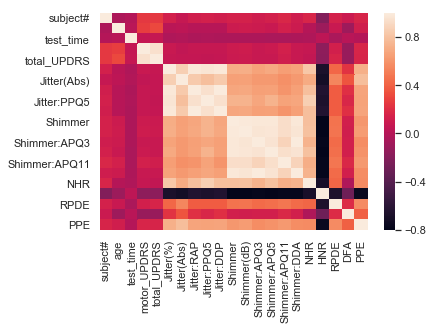

In [7]:
corr = df.corr()
sns.heatmap(corr)

Since we were unable to extract certain vocal features, we had to drop several columns and make do with what can extract.

Apart from vocal features, we drop test time and subject id, because we cannot use this

In [8]:
columns_to_drop = ["subject#","test_time"] + ["NHR","HNR","RPDE","DFA","PPE","Jitter(%)"]
df_new = df.drop(columns=columns_to_drop)
df_new

,age,sex,motor_UPDRS,total_UPDRS,Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA
0,72,M,28.199,34.398,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314
1,72,M,28.447,34.894,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982
2,72,M,28.695,35.389,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202
3,72,M,28.905,35.810,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317
4,72,M,29.187,36.375,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036
5,72,M,29.435,36.870,0.000023,0.00119,0.00159,0.00357,0.02227,0.214,0.01006,0.01337,0.02263,0.03019
6,72,M,29.682,37.363,0.000024,0.00212,0.00221,0.00637,0.04352,0.445,0.02376,0.02621,0.03488,0.07128
7,72,M,29.928,37.857,0.000025,0.00226,0.00259,0.00678,0.02191,0.212,0.00979,0.01462,0.01911,0.02937
8,72,M,30.177,38.353,0.000029,0.00156,0.00207,0.00468,0.04296,0.371,0.01774,0.02134,0.03451,0.05323
9,72,M,30.424,38.849,0.000027,0.00258,0.00253,0.00773,0.03610,0.310,0.02030,0.01970,0.02569,0.06089


In [9]:
df_new.sex.value_counts()

M    4008
F    1867
Name: sex, dtype: int64

### UPDRS Scores
Below we can see marked differences in the distributions of UPDRS scores between men and women. 
  
The distribution of female scores shows the majority are clustered around the mean, with wide tails in both directions. The distribution of male scores is--interestingly enough--pear-shaped (or more specifically, pear-shaped with dual top and bottom stems, shorter and much narrower than those seen in the female UPDRS distribution). Though the male UPDRS average is close to that of the female group, broader quartiles suggest much greater variability in the course of disease for males compared to women. 

[Text(0,0,'Male'), Text(0,0,'Female')]

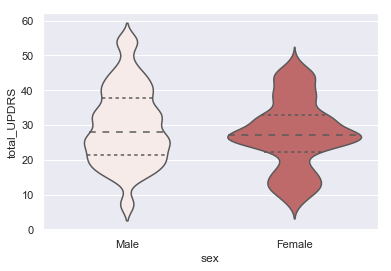

In [10]:
ax = sns.violinplot(x="sex", y="total_UPDRS",  bw=.2, palette={"M": "#f9e9e8", "F": "#CD5C5C"}, inner="quartile", data=df_new)
ax.set_xticklabels(['Male', 'Female'])

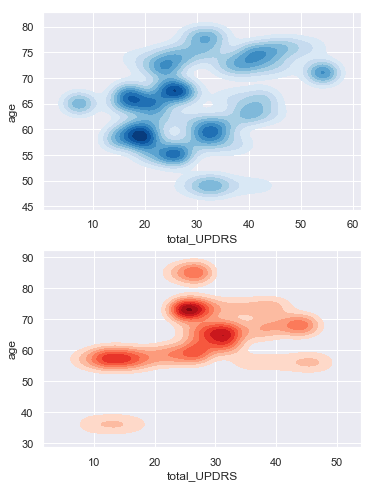

In [11]:
maledf = df_new[df_new.sex=="M"]
femaledf = df_new[df_new.sex=="F"]
f, (ax1, ax2) = plt.subplots(2)
sns.kdeplot(maledf["total_UPDRS"], maledf['age'],
                cmap="Blues", shade=True, shade_lowest=False, ax=ax1)
sns.kdeplot(femaledf["total_UPDRS"], femaledf['age'],
                 cmap="Reds", shade=True, shade_lowest=False, ax=ax2)
f.set_size_inches(5.7, 8)

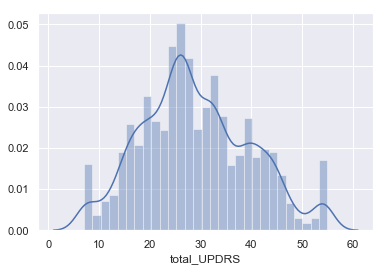

In [12]:
sns.distplot(df_new["total_UPDRS"])

In [13]:
cols = df_new.drop(columns = ["total_UPDRS", "motor_UPDRS","sex","age"]).columns
a = cols[::2]
b = cols[1::2]

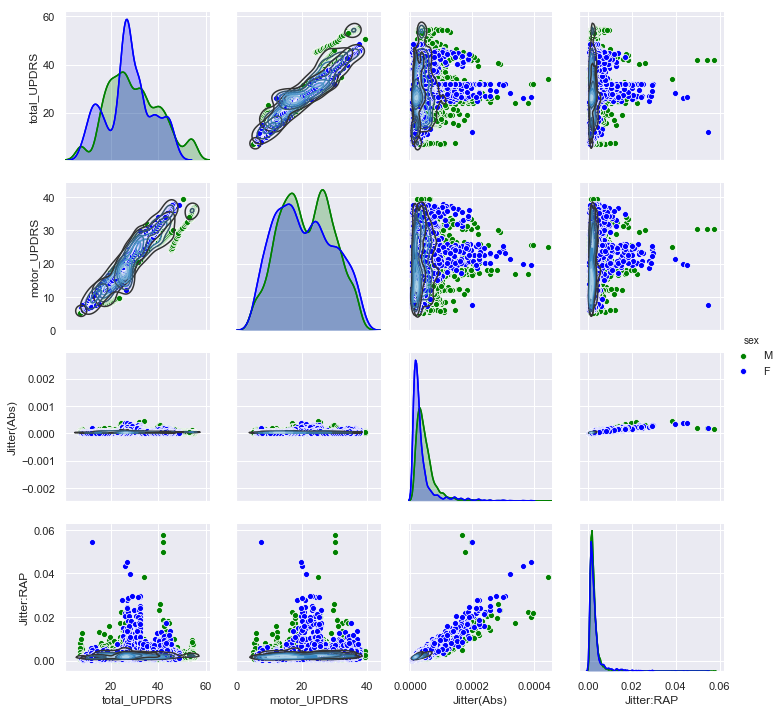

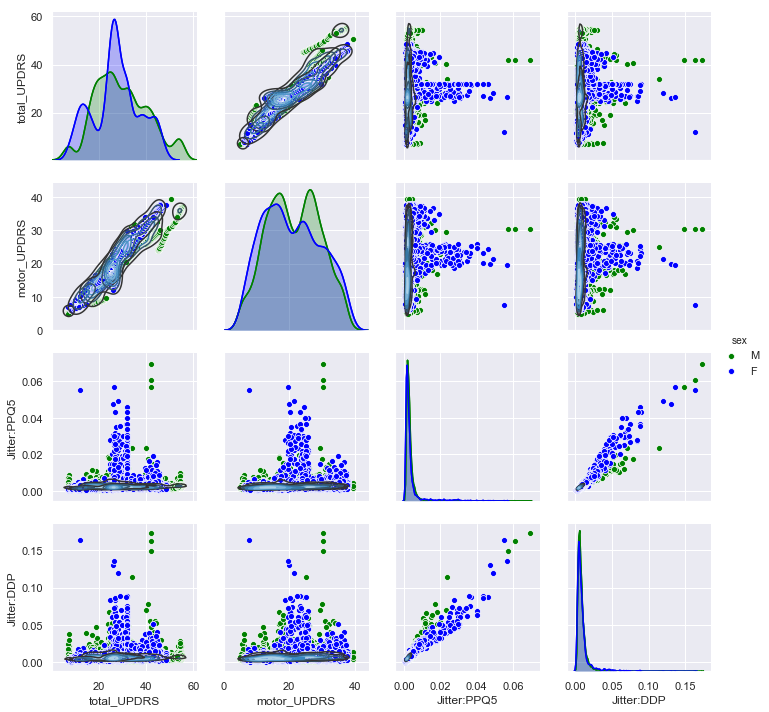

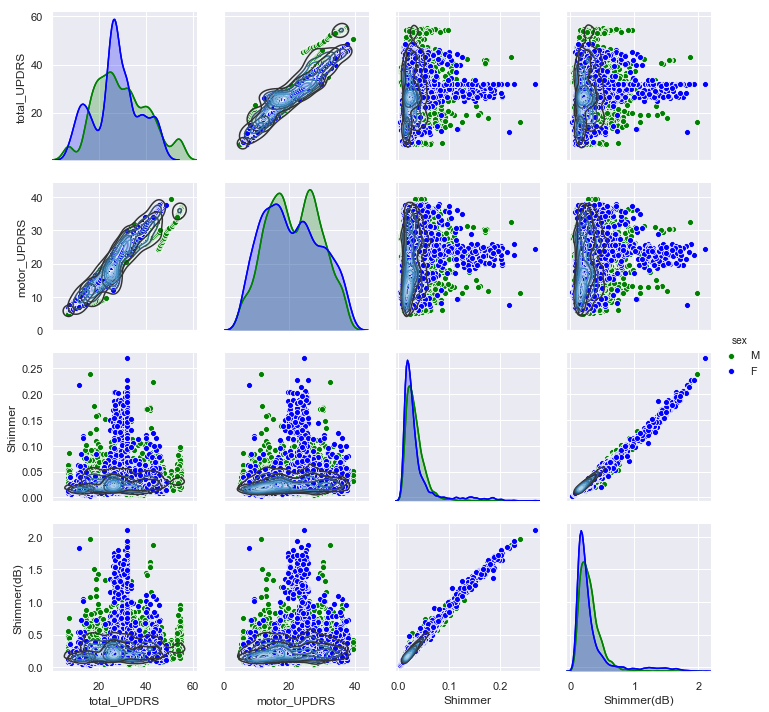

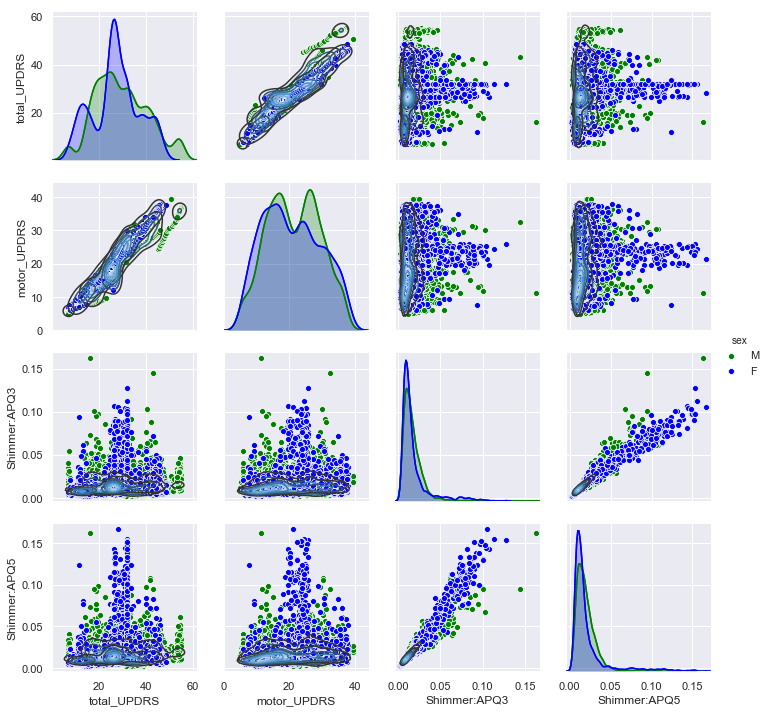

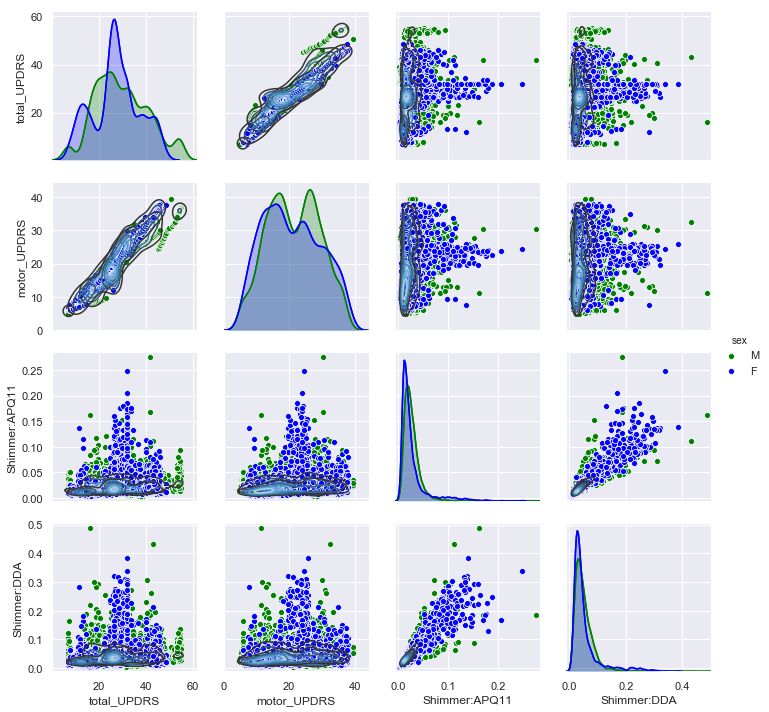

In [14]:
for x,y in zip(a,b):
    g = sns.pairplot(df_new, vars=["total_UPDRS", "motor_UPDRS"]+[x,y], hue="sex",palette={"M": "green", "F": "blue"})
    #g = sns.pairplot(df_new, vars=df_new.drop(columns='sex').columns, hue="sex")
    g.map_diag(sns.kdeplot)
    g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);
    plt.show()

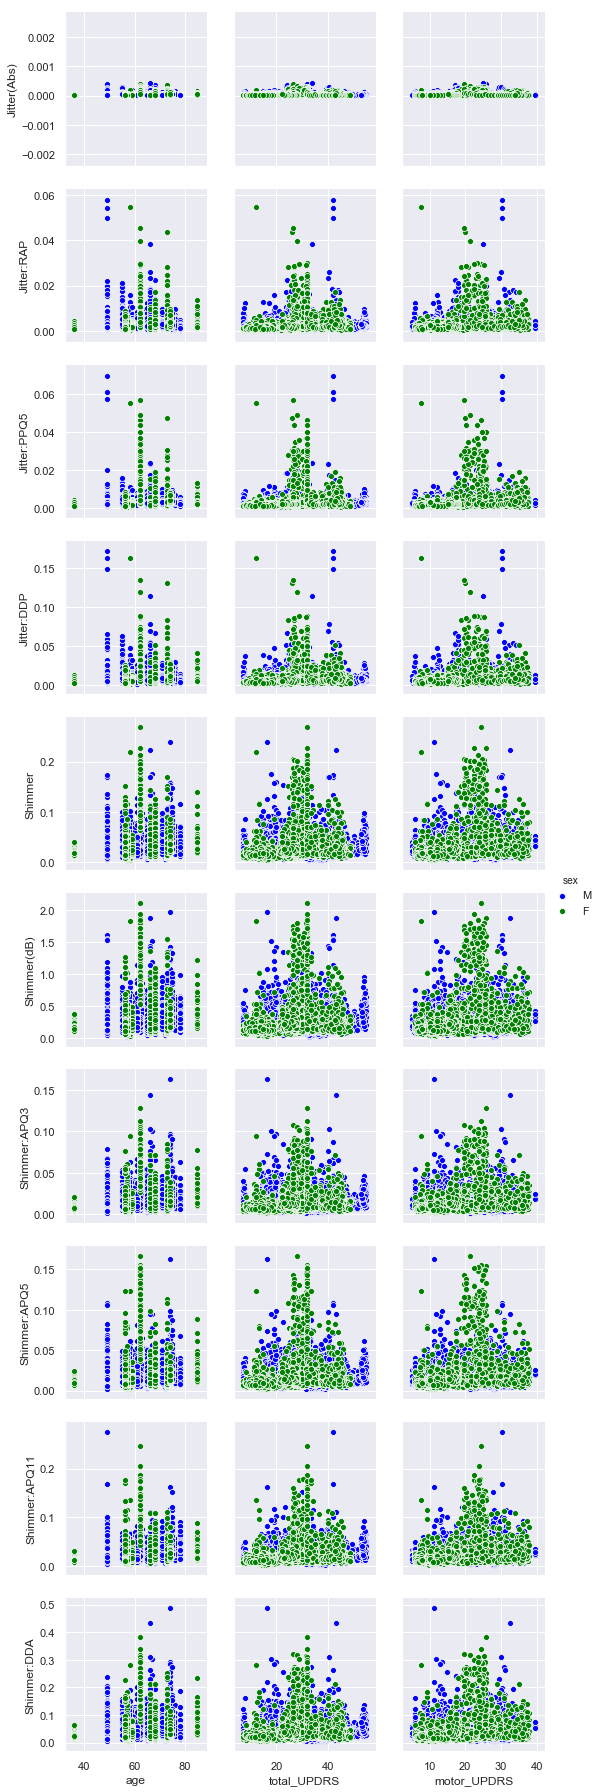

In [15]:
g = sns.pairplot(palette={"M":"blue","F":"green"},hue="sex",diag_kind='kde',data = df_new,x_vars=['age','total_UPDRS','motor_UPDRS'],y_vars=df_new.drop(columns = ['age','total_UPDRS','motor_UPDRS','sex']).columns)
plt.show()

We see that most individuals' scores increase steadily over time in the study, though several subjects maintain or even drastically decrease their scores over the course of the study. 

# Statistical analysis

## Continuous variable comparisions using the pearson correlation test

In [16]:
def pearson_wrapper(df,target,columns=None,verbose=False,alpha=0.05):
    '''Function performs the pearson correlation test of all the columns with the target variable.
    The anova test tests the null hypothesis that the population median of all of the groups are equal.
    
    Parameters
    ----------
    df -> The pandas dataframe
    target -> The target variable you want to test for
    columns -> the specific list of columns you want test. All if not specified.
    '''
    if columns == None:
        columns = [x for x in df.columns if df[x].dtype!='object']
    assert df[target].dtype=='float',"This function can only be used with a quantative target variable"
    for column in columns:
        assert df[column].dtype != 'object',"This function is intended for quantative indipendent variables"
    useful_columns = []
    for column in columns:
            if column == target:
                continue
            print("For "+column+" :-")
            res = scipy.stats.pearsonr(df[column],df[target])
            if verbose:
                print(res)
            if res[1] < alpha :
                print("Reject null hypothesis\n----------------")
                useful_columns.append(column)
            else:
                print("Accept null hypothesis\n----------------")
    print("According to the test, the useful columns are :-\n"+", ".join(useful_columns))

In [17]:
pearson_wrapper(df_new.drop(columns = ["motor_UPDRS"]),"total_UPDRS")

For age :-
Reject null hypothesis
----------------
For Jitter(Abs) :-
Reject null hypothesis
----------------
For Jitter:RAP :-
Reject null hypothesis
----------------
For Jitter:PPQ5 :-
Reject null hypothesis
----------------
For Jitter:DDP :-
Reject null hypothesis
----------------
For Shimmer :-
Reject null hypothesis
----------------
For Shimmer(dB) :-
Reject null hypothesis
----------------
For Shimmer:APQ3 :-
Reject null hypothesis
----------------
For Shimmer:APQ5 :-
Reject null hypothesis
----------------
For Shimmer:APQ11 :-
Reject null hypothesis
----------------
For Shimmer:DDA :-
Reject null hypothesis
----------------
According to the test, the useful columns are :-
age, Jitter(Abs), Jitter:RAP, Jitter:PPQ5, Jitter:DDP, Shimmer, Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, Shimmer:APQ11, Shimmer:DDA


## Categorical variables and UPDRS comparisions

Let's check if the UDPRS scores are normally distributed

In [18]:
scipy.stats.normaltest(df_new["total_UPDRS"])

NormaltestResult(statistic=115.7591182452, pvalue=7.298386492105016e-26)

Normal test results can be understood as follows:-

null hypothesis : x comes from a normal distribution

alternate hypothesis : x doesnot come from a normal distribution

According to test, p value was very less, hence we reject the null hypothesis that total updrs is normally distributed. Hence we perform the non parametric test for age

In [19]:
def kruskal_wallis_wrapper(df,target,columns=None,verbose=False,alpha=0.05):
    '''Function performs the Kruskal-Wallis H-test of all the columns with the target variable.
    The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA.
    
    Parameters
    ----------
    df -> The pandas dataframe
    target -> The target variable you want to test for
    columns -> the specific list of columns you want test. All if not specified.
    '''
    if columns == None:
        columns = [x for x in df.columns if df[x].dtype=='object']
    assert df[target].dtype=='float',"This function can only be used with a quantative target variable"
    for column in columns:
        assert df[column].dtype == 'object',"This function is intended for categorical indipendent variables"
    useful_columns = []
    for column in columns:
            print("For "+column+" :-")
            groups = df.groupby(column)
            data = [groups.get_group(x)[target] for x in groups.groups]
            res = scipy.stats.kruskal(*data)
            if verbose:
                print(res)
            if res.pvalue < alpha :
                print("Reject null hypothesis\n----------------")
                useful_columns.append(column)
            else:
                print("Accept null hypothesis\n----------------")
    print("According to the test, the useful columns are :-\n"+",".join(useful_columns))

In [20]:
kruskal_wallis_wrapper(df_new,"total_UPDRS")

For sex :-
Reject null hypothesis
----------------
According to the test, the useful columns are :-
sex


# Model Building

#### importing required modules:-

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA

d:\installed\pycharmedu4.0.1\anaconda\envs\virtusa\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


##### First lets one hot encode all the categorical features

* In this case, only gender is the categorical features, so we one hot encode the gender

In [22]:
final_df = pd.concat((df_new,pd.get_dummies(df_new.sex)),axis=1).drop(columns = ["sex"])
final_df.head()

,age,motor_UPDRS,total_UPDRS,Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,F,M
0,72,28.199,34.398,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0,1
1,72,28.447,34.894,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0,1
2,72,28.695,35.389,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0,1
3,72,28.905,35.810,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0,1
4,72,29.187,36.375,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0,1


In [23]:
features = final_df.drop(columns =["total_UPDRS","motor_UPDRS"])
targets = final_df[["total_UPDRS","motor_UPDRS"]]
X_train,X_test,y_train,y_test = train_test_split(features,targets,random_state=2,test_size=0.3)
print("Number of features considered :-", len(features.columns))

Number of features considered :- 13


## Now that the features are ready, let's start building the models

### Models considered are:-
<ol>
    <li> Linear Regression </li>
    <li> Ridge Regression </li>
    <li> Lasso Regression </li>
    <li> Multi task Lasso </li>
    <li> Multitask elastic net </li>
    <li> LARS </li>
    <li> OMP </li>
    <li> Kernel Ridge Regression </li>
    <li> Support vector regressor </li>
    <li> Nearest Neighbours regression </li>
    <li> Decision Tree regression</li>
    <li> Extra trees Regressor</li>
    <li> Ada boost regressor</li>
    <li> Gradient boost regressor</li>    
</ol>
Finally we will try the voting classifier for an ensembled result of the best performing models

For each of the models, we will use the grid search to find the best possible hyperparameters. It is computationally expensive but we will not miss out on any model beacuse of poor hyperparameter tuning

In [24]:
def create_pipe_model(model):
    '''
    Returns a pipeline with the 4 steps:-
    1)Scaling the data
    2)Feature selection or dimentionality reducion
    3)Regression
    '''
    return Pipeline([
                  ('scale',preprocessing.Normalizer()),
                  ('feature_selection', SelectFromModel(model)),
                  ('Regression', model)
                    ])
def run_model(pipe,param_dict,verbose=False):
    clf = GridSearchCV(pipe,param_dict,verbose=verbose,n_jobs=njobs).fit(X_train,y_train)
    print("Training score : ",clf.score(X_train,y_train))
    print("Testing score : ",clf.score(X_test,y_test))
    print("Best params : ",clf.best_params_)
    return clf

In [25]:
clfs = {}  #stores all the models
scalers_to_test = [StandardScaler(), RobustScaler(), QuantileTransformer(),None]
njobs = 4

#### Linear Regression

In [26]:
model = linear_model.LinearRegression()
feature_selection = [PCA(),SelectFromModel(model),None]
pipe = create_pipe_model(model)
params = {
    'scale' : scalers_to_test,
    'feature_selection' : feature_selection
}
clfs["Linear_regression"] = run_model(pipe,params)

Training score :  0.12750707808708306
Testing score :  0.13102105481207157
Best params :  {'feature_selection': None, 'scale': QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
          output_distribution='uniform', random_state=None,
          subsample=100000)}


In [27]:
clf = ExtraTreesRegressor()
clf.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
clf.score(X_test,y_test)

0.8922440412603336

In [29]:
clf.score(X_test,y_test)

0.8922440412603336

### To do :-
* **Grid search**
* **Consider other regressors**